In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [7]:
!curl https://raw.githubusercontent.com/carolinamcg/numpy_transformer/master/NNModule.py > NNModule.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1408  100  1408    0     0   3171      0 --:--:-- --:--:-- --:--:--  3164


In [11]:
from NNModule import NNModule

# Introduction

Let's take 2 example-sequences:

> *Animals like birds can fly*

> *Animals like dolphins can swim*

If we want to create a transition matrix that encodes the probability of one word j happening after one word i (Markov Chain), we get:

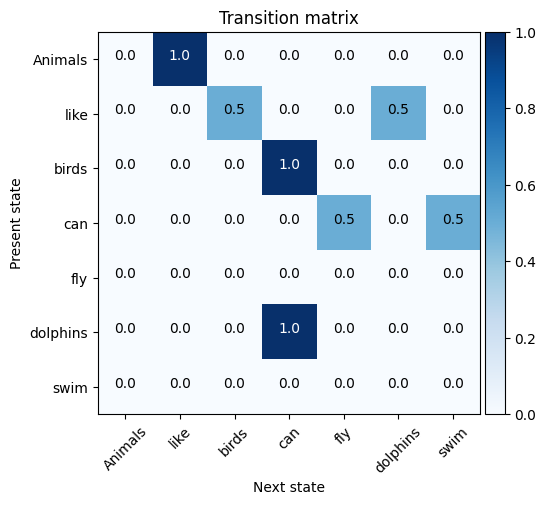

In [ ]:
#to run/create this matrix, u need to first run the code below
# in section "Code to build the transition matrix:"
transition_matrix = markov_chain(X_ids, vocab)

Here, we are only looking to the immediate previous state/word i to predict the probability of the word that comes next. So, if we are at i=3 (can), we have 2 words equally probable to happen. 

*But how could we know wich one will it be?*



*   **Context:** if we look to a combination of (previous) words, instead of just the closest/more recent one, we can reduce uncertainty. For example, if each row in the previous transition matrix corresponded to a pair of words, like *(birds, can)*, the probabilities of *fly* and *swim* would be 1 and 0, respectively.

*   **Masking:** Not all combinations are relevant. For example, if we saw *(that, can)*, we wouldn't be able to discriminate between *fly* or *swim*, but if we saw *(birds, can)*, we'd know for sure that the next word would be *fly*.



***So, how to integrate these concepts to predict sequence elements?*** 
> (How can we build a system that masks the irrelevant information, while combining the important words that describe the sequence at each particular state?)

##### Code to build the transition matrix:

**First, we need to get the indexes for each word**
(doing it by tokeninzing with one-hot encoding)

In [ ]:
def one_hot(num_classes, ids):
    '''
    Converts a vector with all possible indexes/classes in one-hot encoded matrix
    (len(ids), num_classes)
    '''
    return np.squeeze(np.eye(num_classes)[ids.reshape(-1)])

def tokenize_onehot(X, i=0, checkpoint=True):
  vocab = {}
  X = [seq.split(" ") for seq in X]
  X_indexes = []
  for seq in range(len(X)):
    X_indexes.append([])
    for word in X[seq]:
      if word not in vocab.keys():
        vocab[word] = i
        i += 1
      X_indexes[seq].append(vocab[word])
  
  vocab_size = len(vocab.keys())
  X_one_hot = np.array([one_hot(vocab_size, np.array(ids)) for ids in X_indexes])

  if checkpoint:
    print("Vocabulary: ", vocab)
    print("Indexed input words: ", X_indexes)
    print("Enconded words: ", X_one_hot)
  return np.array(X_indexes), X, X_one_hot, vocab

In [ ]:
X = ["Animals like birds can fly",
  "Animals like dolphins can swim"]
X_ids, X_words, one_hot_inputs, vocab = tokenize_onehot(X, i=0)
print(X_ids.shape, one_hot_inputs.shape)

Vocabulary:  {'Animals': 0, 'like': 1, 'birds': 2, 'can': 3, 'fly': 4, 'dolphins': 5, 'swim': 6}
Indexed input words:  [[0, 1, 2, 3, 4], [0, 1, 5, 3, 6]]
Enconded words:  [[[1. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0.]]

 [[1. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1.]]]
(2, 5) (2, 5, 7)


**Then create the markov transition matrix:**

In [ ]:
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
def plot_transition_matrix(cm, classes,
                title='Transition matrix',
                cmap=plt.cm.Blues):
    plt.figure(figsize=(5, 5), dpi=100)

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Present state')
    plt.xlabel('Next state')

    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

In [ ]:
def probabilities(X):
  s = sum(X)
  if s > 1:
    X =X/sum(X)
  return X

def markov_chain(X_ids, vocab, plot=True):
  ''' Assuming all sequences are seen with the same frequency '''
  vocab_size = len(vocab.keys())
  transition_matrix = np.zeros((vocab_size, vocab_size))
  for seq in X_ids:
    for i in range(len(seq)-1):
      transition_matrix[seq[i], seq[i+1]] += 1

  transition_matrix = np.apply_along_axis(probabilities, -1, transition_matrix)
  if plot:
    plot_transition_matrix(transition_matrix, vocab.keys())
  return transition_matrix

def markov_chain(X_ids, vocab, plot=True):
  ''' Assuming all sequences are seen with the same frequency '''
  vocab_size = len(vocab.keys())
  transition_matrix = np.zeros((vocab_size, vocab_size))
  for seq in X_ids:
    for i in range(len(seq)-1):
      transition_matrix[seq[i], seq[i+1]] += 1

  transition_matrix = np.apply_along_axis(probabilities, -1, transition_matrix)
  if plot:
    plot_transition_matrix(transition_matrix, vocab.keys())
  return transition_matrix

# **Attention in Transformers**

Transformers are new state-of-the-art models used to predict sequence elements, by encoding meaningfull representations of its (temporal) context and semantics. The secret-key of how they do it is a specific module called *attention*, which integrates and execute the aforementioned concepts of *selective masking and context*.

## Meaning behind attention

The goal of the attention module in transformers is to encode, for each word, the relevant context behind it. How does attention know the relevant words in a sequence to look at? (for example, what words in the sequence have a semantic similarity/connection to the one in question, what words usually appear together,...)

Let's look at the attention equation:

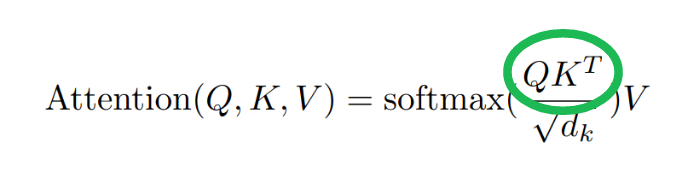

To simplify, consider Q and K of shapes (seq_length, N), where N is the vocab_size, seq_length is the number of words in the sequence and Q is a collection of one-hot encoded vectors:

*   The queries matrix Q represents the **word of interest** for each sequence element (query q).

*   The matrix K represents the **collection of masks, stored in columns**. For each word in N, the respective column (ith-column) in K will indicate the **words in the sequence that are related/relevant somehow to the word encoded in the ith index of N**. 

So, a q corresonding to the ith word (ith column=1) will retrieve the respective mask (1 x seq_length), when multiplying by K^T.

For example, considering the fisrt sentence and taking the word *fly* example:

In [ ]:
seq_ex = X_words[0]
Q = one_hot_inputs[0]
print("Sequence: ", seq_ex)
print("Q matrix's shape: ", Q.shape)

q = Q[seq_ex.index('fly')] #one-hot vector for 'fly'
print("query for 'fly': {}, One-hot index: {}".format(q, vocab['fly']))

Sequence:  ['Animals', 'like', 'birds', 'can', 'fly']
Q matrix's shape:  (5, 7)
query for 'fly': [0. 0. 0. 0. 1. 0. 0.], One-hot index: 4


When multiplying this q with the right K^T ((N, seq_length) = (7, 5)), this will return the attention mask corresponding to the 4th row of K^T, which will be a (1,5) vector that tells us:

> **which words in the sequence should we attend to, when looking at 4th word in the vocabulary (*fly*).**



In [ ]:
def get_attention_maks(Q, K):
    """Computes the normalized attentions weights between each q and k,
    as a scaled dot product"""
    att_scores = np.matmul(
        Q, K.transpose(1,0)
    )  
    return att_scores

In [ ]:
K_hard = np.zeros(Q.shape) #creating K manually
K_hard[:, vocab['fly']] = [0, 0, 1, 1, 1] #only interested in the mask for 'fly', 4th column 
print("query for 'fly': {}, One-hot index: {}".format(q, vocab['fly']))
print("K matrix: ")
print(K_hard)
print("K transpose: ")
print(K_hard.transpose(1,0))

query for 'fly': [0. 0. 0. 0. 1. 0. 0.], One-hot index: 4
K matrix: 
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]
K transpose: 
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [ ]:
A = get_attention_maks(q, K_hard)
print("Mask for 'fly':")
for seq_w, att_score in zip(seq_ex, A):
  print("%s: %i"%(seq_w, att_score))

Mask for 'fly':
Animals: 0
like: 0
birds: 1
can: 1
fly: 1


Let's assume also that V matrix is also a collection of one-hot encoded vectors of dimension N, for each word (shape = (seq_length, N)).

When multiplying this attention vector with V (5, 7), we will get a linear combination of all the relevant words marked in A. So, for the word *fly*, we get a final output vector h which combines the relevant words to describe it (*birds*, index 2; *can*, index 3; *fly*, index 4).

In [ ]:
V = one_hot_inputs[0]
h = np.matmul(A, V) 
print(h)

[0. 0. 1. 1. 1. 0. 0.]


Therefore, only the neurons for *birds*, *can* and *fly* are active in `h`(selective attention: context + masking).

## Embedded space

Until now, we've made simplistic assumptions to facilitate the understanding of the attention mechanism. The truth is that transformers are big models, so having vectors which dimension is equal to total vocabulary size (N) would lead to large complexity (O(N^2)) and computalional load.

So, to workaround this problem, each word is represented as **dense embedded vectors**, rather than one-hot vectors.

### How do we create **word embeddings**?



1.   In a one-hot representation of a language, there is one vector element for each word. For a vocabulary of size N that vector is an **N-dimensional space**. Each word represents a **point in that space**, one unit away from the origin along one of the many axes.
2.   In an embedding, those **word points** are all taken and **projected into a lower-dimensional space**.
3.   We do this trough matrix multiplication, where **each one-hot encoded vector (1 x N)** is multiplied by an **embedding matrix (N x d_model)**, returning a **new representation of that word (1 x d_model)**. Here, d_model correspondes to the embedding dimensions.



In [12]:
class Embeddings(NNModule):
    def __init__(self, d_model, vocab_size, max_position_embeddings, p, layer_name="Emb"):
        super().__init__()
        self.vocab_size = vocab_size
        self.word_embeddings = self.Embedding(vocab_size, d_model, padding_idx=1, layer_name="W_"+layer_name)
        #self.position_embeddings = self.Embedding(max_position_embeddings, d_model)
        self.position_embeddings = self.create_sinusoidal_embeddings(
            nb_p=max_position_embeddings, dim=d_model #, E=self.position_embeddings
        ) #(max_position_embeddings, d_model)

        self.LayerNorm = LayerNormalization(normal_shape=d_model, epsilon=1e-12)

    def Embedding(self, N, emb_dim, padding_idx=1, layer_name="Emb"):
        """
        Creates a matrix with all possible embeddings: 1 embedding of dim=d_model for each possible word
        :param N: total number of existinng words/tokens/positions in the current task/problem
        :param emb_dim: dimension of each embedding vector (for each word/token)

        :output w_emb (N, emb_dim): embeddings weights array. Transforms each one-hot vector/word into the corresponding embedding, by the index set to 1

        """
        w_emb, _ = self.get_parameters((N, emb_dim), layer_name=layer_name, bias=False)
        #w_emb = np.random.random((N, emb_dim))
        return w_emb
    
    def one_hot(self, num_classes, ids):
        '''
        Converts a vector with all possible indexes/classes in one-hot encoded matrix
        (len(ids), num_classes)
        '''
        return np.squeeze(np.eye(num_classes)[ids.reshape(-1)])

    def create_sinusoidal_embeddings(self, nb_p, dim):
        E = np.random.random((nb_p, dim))
        theta = np.array(
            [
                [p / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)]
                for p in range(nb_p)
            ]
        )
        E[:, 0::2] = np.sin(theta[:, 0::2]) #(max_position_embeddings, d_model)
        E[:, 1::2] = np.cos(theta[:, 1::2]) #odd indexes in the emb dimension = cos

        return E

    def forward(self, indexed_tokens):
        '''
        :param one_hot_inputs: (seq_length, vocab_size) array. eaxh row corresponds 
        to a token/word and the column idx=1 identifies which word from the total vocabulary/dictionary is
        '''
        bs, seq_length = indexed_tokens.shape #one_hot_inputs.shape[-2]
        one_hot_inputs = np.array([self.one_hot(self.vocab_size, ids) for ids in indexed_tokens])
        position_ids = self.one_hot(seq_length, np.arange(seq_length)) # (max_seq_length, max_seq_length)
                # marks positions inside each sequence

        # Get word embeddings for each input token (one_hot_inputs = ())
        word_embeddings = np.matmul(one_hot_inputs, self.word_embeddings) # (max_seq_length, d_model)

        # Get position embeddings for each position id
        position_embeddings = np.matmul(position_ids, self.position_embeddings) # (max_seq_length, d_model)

        # Add them both
        embeddings = word_embeddings + position_embeddings  # (max_seq_length, d_model)

        # Layer norm
        embeddings = self.LayerNorm.forward(embeddings)  # (max_seq_length, d_model)
        
        return embeddings, word_embeddings, position_embeddings

**Advantages**

A good embedding **groups words with similar meanings together**. A model that works with an embedding learns patterns in the embedded space. That means that whatever it learns to do with one word automatically gets applied to all the words right next to it. This has the added benefit of reducing the amount of training data needed. Each example gives a little bit of **learning that gets applied across a whole neighborhood of words.**

**Watch out for accuracy**

An embedding reduces the number of parameters needed by a tremendous amount. However, the fewer the dimensions in the embedded space, the more information about the original words gets discarded. The richness of a language still requires quite a bit of space to lay out all the important concepts so that they don't step on each other's toes. By choosing the size of the embedded space, we get to **trade off computational load for model accuracy.**

### Positional Embeddings

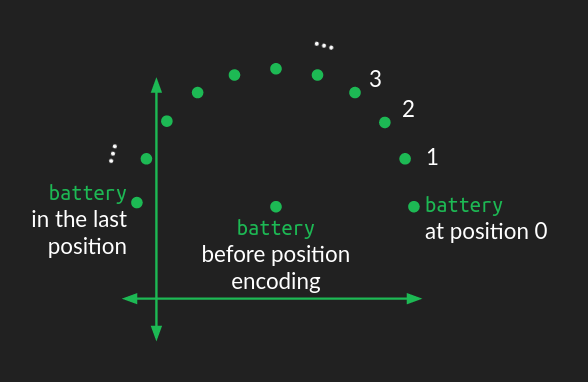

The position of the word in the embedding space acts as the center of a circle. A perturbation is added to it, depending on where it falls in the order of the sequence of words. For each position, the word is moved the same distance but at a different angle, resulting in a circular pattern as you move through the sequence. Words that are close to each other in the sequence have similar perturbations, but words that are far apart are perturbed in different directions. 

Since a circle is a two dimensional figure, representing a circular wiggle requires modifying two dimensions of the embedding space. If the embedding space consists of more than two dimensions (which it almost always does), the circular wiggle is repeated in all the other pairs of dimensions, but with different angular frequency, that is, it sweeps out a different number of rotations in each case. In some dimension pairs, the wiggle will sweep out many rotations of the circle. In other pairs, it will only sweep out a small fraction of a rotation. The combination of all these circular wiggles of different frequencies gives a good representation of the absolute position of a word within the sequence. 

This positional embeddings are than added to the word embeddings:

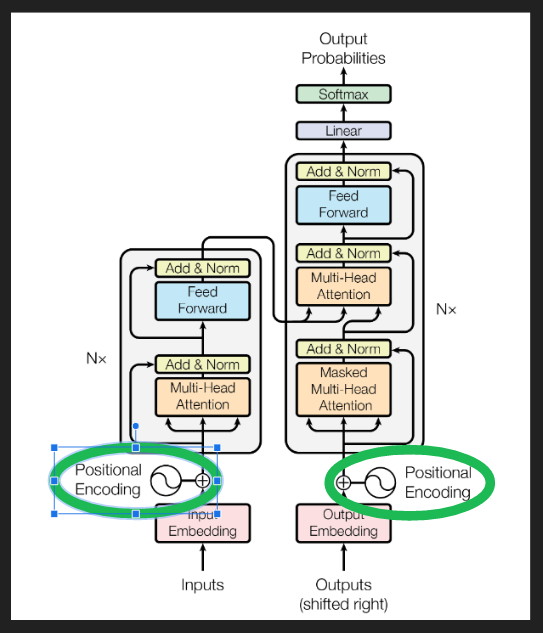

## Attention with dense vectors

So, Q and K are actually of dimension **(seq_length x d_model)**, instead of (seq_length x N). This means that:

*   The query Q represents the **feature groups of interest** for each sequence element/word.

*   The matrix K represents the collection of masks, stored in columns. For **each embedded dimension (group of features)**, the respective column in K will indicate the **sequence elements that are related or share similar properties to those encoded by that embedded dimension.**

Therefore, when multiplying a q (1 x d_model) with K^T (d_model x seq_length) we are actually looking for the words in the sequence that are related to/share the **same or similar features in the embedded space as our q**. It's not about how equal q vector is to each k, whereas **if they "activate" the same neurons.**




In [ ]:
def softmax(X):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(X - np.max(X))
    return e_x / e_x.sum()

def get_attention_weights(Q, K, plot=False):
    """Computes the normalized attentions weights between each q and k,
    as a scaled dot product"""
    KT = K.transpose(1, 0)
    att_scores = np.matmul(
        Q, KT
    )  #(batch size, num_heads, seq_length, seq_length)
    att_scores = att_scores / math.sqrt(K.shape[-1])
    
    if plot:
      _, b = plt.subplots(1, 4, figsize=(10,10))
      b[0].set_title("Queries")
      b[0].get_yaxis().set_visible(False)
      b[0].imshow(Q)
      b[0].set_xlabel("Embedded dims")
      b[1].set_title("Keys")
      b[1].imshow(K)
      b[1].get_yaxis().set_visible(False)
      b[1].set_xlabel("Embedded dims")
      b[2].set_title("K^T")
      b[2].imshow(KT)
      b[2].get_yaxis().set_visible(False)
      b[2].set_xlabel("Keys")
      b[3].set_title("Attention Scores")
      b[3].imshow(att_scores)
      b[3].get_yaxis().set_visible(False)
      #b[2].set_ylabel("Queries")
      b[3].set_xlabel("Keys")

    print("Attention scores are: {}".format(att_scores.squeeze()))
    att_weights = np.apply_along_axis(softmax, -1, att_scores) #-inf values -> 0
    return att_weights

def get_values_attention(Q, K, V, plot=False):
    '''Get the linear combination of values for each query'''
    A = get_attention_weights(Q, K, plot=plot)
    H = np.matmul(A, V) #(bs, num_heads, seq_length, self.d)

    '''
    if plot:
      _, b = plt.subplots(1, 3, figsize=(10,10))
      b[0].set_title("Attention Weights")
      b[0].get_yaxis().set_visible(False)
      b[0].imshow(A)
      b[0].set_xlabel("Keys")
      b[1].set_title("Values")
      b[1].imshow(V)
      b[1].get_yaxis().set_visible(False)
      b[1].set_xlabel("Embedded dims")
      b[2].set_title("Output vectors H")
      b[2].imshow(H)
      b[2].get_yaxis().set_visible(False)
      b[2].set_xlabel("Embedded dims")
    '''
    return H, A

def print_out(Q, K, V, plot=False):
    temp_out, temp_attn = get_values_attention(Q, K, V, plot=plot)
    print('Attention weights are:', temp_attn.squeeze())
    print('Output is:', temp_out.squeeze())

### Example 1

Attention scores are: [[57.73502692  0.          0.        ]
 [57.73502692  0.          0.        ]]
Attention weights are: [[1.0000000e+00 8.4332776e-26 8.4332776e-26]
 [1.0000000e+00 8.4332776e-26 8.4332776e-26]]
Output is: [[1.00000000e+01 9.27660536e-25 0.00000000e+00]
 [1.00000000e+01 9.27660536e-25 0.00000000e+00]]


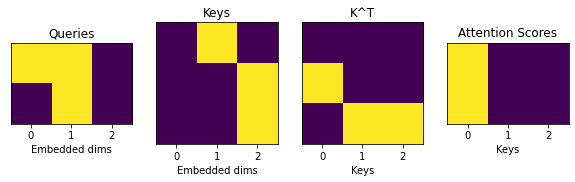

In [ ]:
test_K =np.array(
    [[ 0,10, 0],
     [ 0, 0,10],
     [ 0, 0,10]]
)

test_V = np.array(
    [[  10,0,0],
     [ 100,5,0],
     [1000,6,0]]
)

test_Q = np.array(
    [[10, 10, 0],
     [0, 10, 0]]
)

print_out(test_Q, test_K, test_V, plot=True)

The 2 queries in this example differ in the first embedded dimension. Although the 2nd query = the first key ([0, 10, 0]), the attention score/weights between the two q and K are exactly the same: both q attend to the first k only, because this is the only k that is related to/triggers neurons/embedded dimensions also present/active in Q, sharing similar semantics/features.

This shows that what matters in attention is not exact resemblance between embedded vectors, but wether this vectors share/active similar embedded dimensions, which means they're somehow related/close to each other in the embedded space.

For each query, the output was then equal to the 1st value in V.

### Example 2

If we give a query that matches two keys exactly, it should return the averaged value of the two values for those two keys. 

Attention scores are: [ 0.         57.73502692 57.73502692]
Attention weights are: [4.2166388e-26 5.0000000e-01 5.0000000e-01]
Output is: [550.    5.5   0. ]


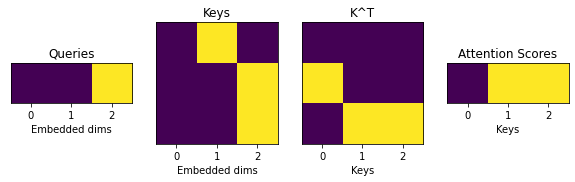

In [ ]:
'''
test_K =np.array(
    [[ 0,10, 0],
     [ 0, 0,10],
     [ 0, 0,10]]
)

test_V = np.array(
    [[  10,0,0],
     [ 100,5,0],
     [1000,6,0]]
)
'''
test_Q = np.array([[0, 0, 10]])
print_out(test_Q, test_K, test_V, plot=True)

We see that it focuses equally on the 2nd and 3rd keys and returns the average of their values. So, for this q, the 2 last words in the sequence are equally important, so its final (context) output vector will reflect both values.

Therefore, the **H matrix** reflects, for each row (query), the **features that describe the sequence at that point.**


### Example 3

Now giving all the queries at the same time:


Attention scores are: [[57.73502692  0.          0.        ]
 [57.73502692  0.          0.        ]
 [ 0.         57.73502692 57.73502692]]
Attention weights are: [[1.0000000e+00 8.4332776e-26 8.4332776e-26]
 [1.0000000e+00 8.4332776e-26 8.4332776e-26]
 [4.2166388e-26 5.0000000e-01 5.0000000e-01]]
Output is: [[1.00000000e+01 9.27660536e-25 0.00000000e+00]
 [1.00000000e+01 9.27660536e-25 0.00000000e+00]
 [5.50000000e+02 5.50000000e+00 0.00000000e+00]]


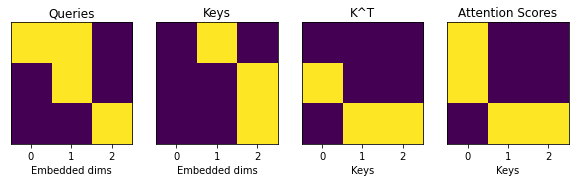

In [ ]:
test_K =np.array(
    [[ 0,10, 0],
     [ 0, 0,10],
     [ 0, 0,10]]
)

test_V = np.array(
    [[  10,0,0],
     [ 100,5,0],
     [1000,6,0]]
)

test_Q = np.array(
    [[10, 10, 0], [0, 10, 0], [0, 0, 10]]
)

print_out(test_Q, test_K, test_V, plot=True)

## Multi-Head Attention

In tranformers, not only words are represented as dense embedded vectors, rather than one-hot vectors. Also attention is not just 1 or 0, on or off, but can also be anywhere in between. To get the results to fall between 0 and 1, we use the softmax trick again. It has the dual benefit of forcing all the values to lie in our [0, 1] attention range, and it helps to emphasize the highest value, while agressively squashing the smallest (differential almost-argmax behavior).

**Limitation**
> A complicating consequence of putting a softmax function in attention is that it will **tend to focus on a single element.** And sometimes it's useful to keep several of the preceding words in mind when predicting the next, and the softmax just robbed us of that. This is a problem for the model.


**Solution: Multi-Head Attention**
> Have several different instances of attention, or heads running at once. This lets the the transformer **consider several previous words simultaneously when predicting the next/maked one.**
Unfortunately, doing this really increases the computational load. Computing attention was already the bulk of the work, and we just multiplied it by however many heads we want to use. To get around this, we can re-use the trick of projecting everything into a lower-dimensional embedding space. So, projecting the input embeddings (d_model) to a smaller hidden size dimension for keys, queris (d_k = d_q) and values (d_v).

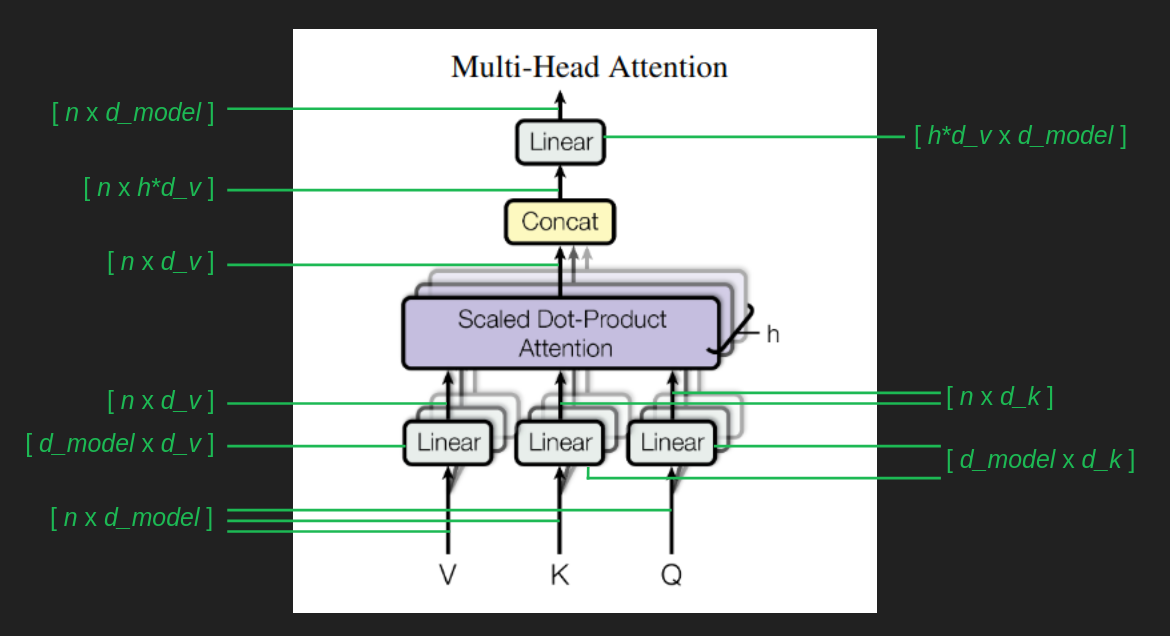

The final linear layer in the above image learns a matrix W_h that concatenates all heads' outputs into one vector for each word/sequence element. 



*   W_h shape = (num_heads*d_v x d_model), projecting the attention outputs H to the orginal input/output embeddings.



In [13]:
class MultiHeadAttention(NNModule):
    def __init__(self, hidden_size, num_heads, d_model, p, layer_name="EncL"):
        super().__init__()
        self.num_heads = num_heads #number of q, k, v per token x
        self.d = hidden_size #dimension of each query, value and key
        self.d_model = d_model #dimension of the input/output embeddings
        self.layer_name = layer_name

        # Weight matrices to compute Q, K, V from input embeddings (emb dim, hidden dim for each head)
        # each attention head has its own Wv, Wq, and Wk transforms.
        self.W_q, _ = self.get_parameters((d_model, self.d * num_heads), layer_name=layer_name +"_Q", bias=False)
        self.W_k, _ = self.get_parameters((d_model, self.d * num_heads), layer_name=layer_name +"_K", bias=False)
        self.W_v, _ = self.get_parameters((d_model, self.d * num_heads), layer_name=layer_name +"_V", bias=False)

        # Outputs of all sub-layers need to be of dimension self.d_model
        self.W_h, self.bias_h = self.get_parameters((self.num_heads * self.d, self.d_model), layer_name=layer_name +"_H")
        #converts each final value vector computed for each input token/query into 1 single vector w/ dimension=d_model=d_model --> weighted sum over all the heads per query/token

    def softmax(self, X):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(X - np.max(X))
        return e_x / e_x.sum()

    def split_heads(self, X):
        """
        Split the last dimension into (num_heads, hidden size): X -> (num_heads, bs, seq_length, self.d)
        Return after transpose to put in shape (bs, num_heads, seq_length, self.d)

        :param X (3D array): Q, K or V w/ shape (bs, seq_length, num_heads*self.d)
        """
        return np.array(np.split(X, self.num_heads, axis=-1)).transpose(1, 0, 2, 3)
    
    def get_attention_weights(self, Q, K, mask=None):
        """Computes the normalized attentions weights between each q and k,
        as a scaled dot product"""
        att_scores = np.matmul(
            Q, K.transpose(0, 1, 3, 2)
        )  #(batch size, num_heads, seq_length, seq_length)
        att_scores = att_scores / math.sqrt(self.d)

        if mask is not None: #for training decoder (not autorregresive)
            #bu only for self attention, not cross
            #mask = np.tril(np.ones(att_scores.shape[2:])) 
            att_scores[:,:, mask==0] = -math.inf #elements above the k-th diagonal = -inf
        
        att_weights = np.apply_along_axis(self.softmax, -1, att_scores) #-inf values -> 0
        return att_weights

    def get_values_attention(self, Q, K, V, mask=None):
        '''Get the linear combination of values for each query'''
        A = self.get_attention_weights(Q, K, mask=mask)
        H = np.matmul(A, V) #(bs, num_heads, seq_length, self.d)
        return H, A
    
    def forward(self, X, mask=None):
        bs, seq_length, _ = X.shape # (bs, number of tokens, emdedding_dimensions=d_model)

        #Compute all q, k and v for each word in X (seq_length)
        Q = np.matmul(X, self.W_q) #(bs, seq_length, self.d * number_heads)
        K = np.matmul(X, self.W_k) #contains every k: each token in each sequence has num_heads keys
        V = np.matmul(X, self.W_v)
        #Split q, k and v per head
        Q = self.split_heads(Q) #(bs, num_heads, seq_length, self.d)
        K = self.split_heads(K)
        V = self.split_heads(V)

        # Calculate the attention weights for each of the heads
        H_cat, A = self.get_values_attention(Q, K, V, mask=mask) #H_cat = (bs, num_heads, seq_length, self.d)

        # Merge heads outputs into the last array's dimension
        H_cat = H_cat.transpose(0,2,1,3).reshape(bs, seq_length, -1) #(bs, seq_length, self.d * number_heads)
        
        # Final linear layer  
        H = np.matmul(H_cat, self.W_h) + self.bias_h # (bs, seq_length, self.d_model)

        return H, A

# Feed-Foward Mechanism

So, each attention head associates each query to one key, producing final output that encodes a pair of words per row/query. We then concatenate all the heads' output, creating a final H matrix that encodes num_heads pairs of words (full selective context). Now, how do we translate those to language agnostic multi-word combination representations/features?

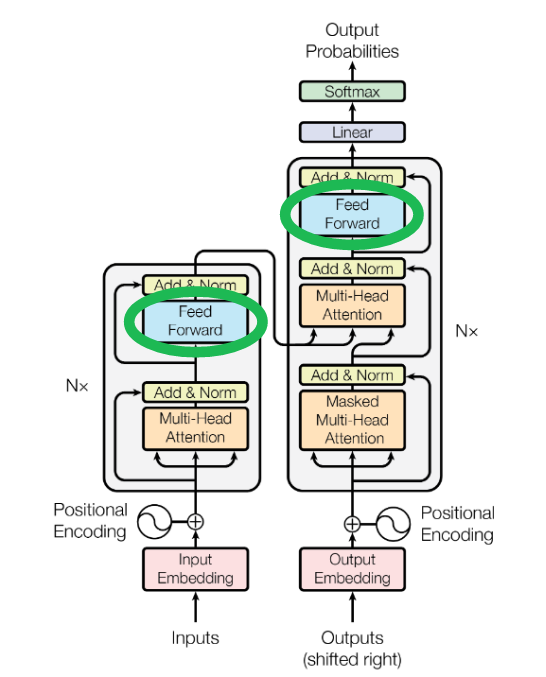

1.   We use a linear layer to convert H (seq_length x d_model) to (seq_length x hidden_dim).

*   W1 matrix's shape = (d_model x hidden_dim + bias1), where each column (hidden dimension) will represent a multi-word combination feature and how each embedded dimension of d_model relates to it --> ***Multi-word feature creation matrix***.
*   Are the words represented in each row of H (sequence element's context vector h) **present or absent in each multi-word combination feature** (hidden dimension)? The output will encode this information, for each h.

2. A ReLu to clean up these results so they represent the presence (>0) or absence (with a 0) of each multi_word combination feature in each sequence element.

3. A second linear layer projects this output (seq_length x hidden_dim) back to the original embedding space (seq_length x d_model), resulting in a probability distribution over this dimensions.

*   W2 matrix's shape = (hidden_dim x d_model + bias2): **each column** indicates the **probability of each embedded feature/group happening, knowing that certain multi-word combination features (rows) happened** --> ***Selective Transition Matrix***.
*   Final output is the H_enc or H_dec, where each sequence element/word (row) contains a **probability distribution over the embedded dimensions**, (hopefully) representing the future/masked word at that position.





In [ ]:
class CNN(NNModule):
'''
This feed-foward module can be seen as a 1D Convolution with kernel size = 1 and
d channels (d=d_model for k1convL1, d=conv_hidden_dim for k1convL2). So, each 
kernel (weight matrix column) is applied to each sequence element/word/timestep 
in X (temporal sharing of parameters)
'''
    def __init__(self, d_model, conv_hidden_dim, layer_name="CNN"):
        super().__init__()
        self.k1convL1, self.bias1 = self.get_parameters((d_model, conv_hidden_dim), layer_name=layer_name)
        self.k1convL2, self.bias2 = self.get_parameters((conv_hidden_dim, d_model), layer_name=layer_name)

    def ReLU(self, X):
        return np.maximum(0,X)

    def forward(self, X):
        X = np.matmul(X, self.k1convL1) + self.bias1
        X = self.ReLU(X)
        X = np.matmul(X, self.k1convL2) + self.bias2
        return X

# De-Embeddings

After this, we need to convert our output embedded vectors into words from the original vocabulary. De-embedding is done the same way embeddings are done, with a projection from one space to another, that is, a matrix multiplication.

The de-embedding matrix is the same shape as the embedding matrix, but with the number of rows and columns flipped: **(d_model x N)**, where N=vocabulary size (size of the one-hot representation of the full vocabulary).

When an embedded vector representing, say, the word *fly* is multiplied by the de-embedding matrix, the value in the corresponding position is high. However, because of how projection to higher dimensional spaces works, the values associated with the other words won't be zero. The words closest to *fly* in the embedded space will also have medium-high values. Other words will have near zero value. And there will likely be a lot of words with negative values. The output vector in vocabulary space will no longer be one-hot or sparse. It will be dense, with nearly all values non-zero. 

**How do we retrieve from here the final one-hot encoded vector?**

The argmax function is "hard" in the sense that the highest value wins, even if it is only infinitessimally larger than the others. If we want to entertain several possibilities at once, it's better to have a "soft" maximum function, which we get from softmax.

If one word scores clearly higher than the others, softmax will exaggerate that difference, making it look almost like an argmax, with the winning value close to one and all the others close to zero. However, if there are several words that all come out close to the top, it will preserve them all as highly probable, rather than artifically crushing close second place results. 

Together the de-embedding transform (shown as the Linear block below) and a softmax function complete the de-embedding process.

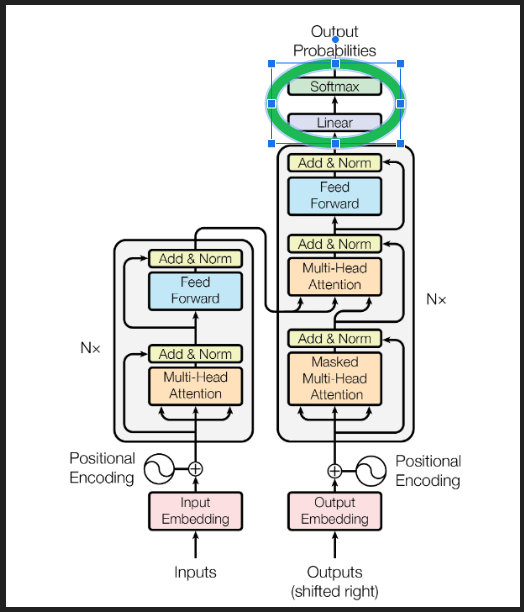

In [ ]:
class Embeddings(NNModule):
    def __init__(self, d_model, vocab_size, max_position_embeddings, p, layer_name="Emb"):
        super().__init__()
        self.vocab_size = vocab_size
        self.word_embeddings = self.Embedding(vocab_size, d_model, padding_idx=1, layer_name="W_"+layer_name)
        #self.position_embeddings = self.Embedding(max_position_embeddings, d_model)
        self.position_embeddings = self.create_sinusoidal_embeddings(
            nb_p=max_position_embeddings, dim=d_model #, E=self.position_embeddings
        ) #(max_position_embeddings, d_model)

        self.LayerNorm = LayerNormalization(normal_shape=d_model, epsilon=1e-12)

    def Embedding(self, N, emb_dim, padding_idx=1, layer_name="Emb"):
        """
        Creates a matrix with all possible embeddings: 1 embedding of dim=d_model for each possible word
        :param N: total number of existinng words/tokens/positions in the current task/problem
        :param emb_dim: dimension of each embedding vector (for each word/token)

        :output w_emb (N, emb_dim): embeddings weights array. Transforms each one-hot vector/word into the corresponding embedding, by the index set to 1

        """
        w_emb, _ = self.get_parameters((N, emb_dim), layer_name=layer_name, bias=False)
        #w_emb = np.random.random((N, emb_dim))
        return w_emb
    
    def one_hot(self, num_classes, ids):
        '''
        Converts a vector with all possible indexes/classes in one-hot encoded matrix
        (len(ids), num_classes)
        '''
        return np.squeeze(np.eye(num_classes)[ids.reshape(-1)])

    def create_sinusoidal_embeddings(self, nb_p, dim):
        E = np.random.random((nb_p, dim))
        theta = np.array(
            [
                [p / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)]
                for p in range(nb_p)
            ]
        )
        E[:, 0::2] = np.sin(theta[:, 0::2]) #(max_position_embeddings, d_model)
        E[:, 1::2] = np.cos(theta[:, 1::2]) #odd indexes in the emb dimension = cos

        return E

    def softmax(self, X):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(X - np.max(X))
        return e_x / e_x.sum()

    def forward(self, indexed_tokens):
        '''
        :param one_hot_inputs: (seq_length, vocab_size) array. eaxh row corresponds 
        to a token/word and the column idx=1 identifies which word from the total vocabulary/dictionary is
        '''
        bs, seq_length = indexed_tokens.shape #one_hot_inputs.shape[-2]
        one_hot_inputs = np.array([self.one_hot(self.vocab_size, ids) for ids in indexed_tokens])
        position_ids = self.one_hot(seq_length, np.arange(seq_length)) # (max_seq_length, max_seq_length)
                # marks positions inside each sequence

        # Get word embeddings for each input token (one_hot_inputs = ())
        word_embeddings = np.matmul(one_hot_inputs, self.word_embeddings) # (max_seq_length, d_model)

        # Get position embeddings for each position id
        position_embeddings = np.matmul(position_ids, self.position_embeddings) # (max_seq_length, d_model)

        # Add them both
        embeddings = word_embeddings + position_embeddings  # (max_seq_length, d_model)

        # Layer norm
        embeddings = self.LayerNorm.forward(embeddings)  # (max_seq_length, d_model)
        
        return embeddings, word_embeddings, position_embeddings

    def de_embedd(self, X):
        ''' Final linear layer + softmax to convert the embedded vectors to vocabulary words'''
        words_probabilities = np.matmul(X, self.word_embeddings.transpose(1,0))
        one_hot_words = np.apply_along_axis(self.softmax, -1, words_probabilities) 

        return one_hot_words

# Final Aspects

### **Skip Connections (ADD):**



*   Prevent vanishing gradients.
*   Preserve the original input sequence, so there's no way the original word's will be forgotten/dropped during attentio (because attention may not attend to the word itself).

### **Layer Normalization (NORM):**

In [ ]:
class LayerNormalization(NNModule):
    def __init__(self,
                 normal_shape,
                 gamma=True,
                 beta=True,
                 epsilon=1e-10, layer_name="LayerNorm"):
        """Layer normalization layer
            See: [Layer Normalization](https://arxiv.org/pdf/1607.06450.pdf)
            https://github.com/CyberZHG/torch-layer-normalization/blob/89f405b60f53f85da6f03fe685c190ef394ce50c/torch_layer_normalization/layer_normalization.py#L8

            :param normal_shape: The shape of the input tensor or the last dimension of the input tensor (dimension over which LayerNorm is applied)
            :param gamma: Add a scale parameter if it is True.
            :param beta: Add an offset parameter if it is True.
            :param epsilon: Epsilon for calculating variance. """
        super().__init__()
        if isinstance(normal_shape, int):
            normal_shape = (normal_shape,)
        else:
            normal_shape = (normal_shape[-1],)

        self.epsilon = epsilon
        if gamma:
            self.gamma, _ = self.get_parameters(normal_shape, layer_name=layer_name + "_gamma", bias=False) #(hidden_size of this layer's input, 1)
        if beta:
            self.beta, _ = self.get_parameters(normal_shape, layer_name=layer_name + "_beta", bias=False) #(hidden_size, 1)

    def forward(self, X):
        mean = X.mean(axis=-1, keepdims=True) # mean of each columns/dimension/hidden unit
        var = ((X - mean) ** 2).mean(axis=-1, keepdims=True)
        std = np.sqrt(var + self.epsilon)
        y = (X - mean) / std
        if self.gamma is not None:
            y *= self.gamma
        if self.beta is not None:
            y += self.beta
        return y

### **Multiple Layers:**



*   Provide redundancy, optimizing convergency: if one layer misses its purpose of finding its optimal parameters, there's others that might do it for her.
*   Improvement becomes marginal after 6 layers (paper: *Attention is all you need*).

### **Cross-Attention:**



*   Connection block between encoder and decoder (*e.g.:* for translation tasks).
*   Here, the queries relate to the output (final language) context vectors from the decoder's self-attention. The keys and values are computed from the input embedded vectors (original language).
*   These keys and values are fed to each decoder's layer and attention head.
*   Final attention's output (H) encodes the context present in the original (input) language that is relevant to each output word (final language).


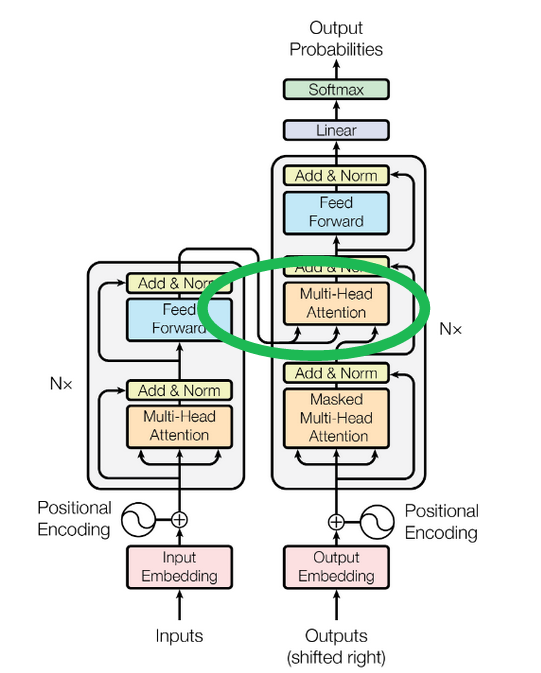

In [ ]:
class MultiHeadAttention(NNModule):
    def __init__(self, hidden_size, num_heads, d_model, p, layer_name="EncL"):
        super().__init__()
        self.num_heads = num_heads #number of q, k, v per token x
        self.d = hidden_size #dimension of each query, value and key
        self.d_model = d_model #dimension of the input/output embeddings
        self.layer_name = layer_name

        # Weight matrices to compute Q, K, V from input embeddings (emb dim, hidden dim for each head)
        # each attention head has its own Wv, Wq, and Wk transforms.
        self.W_q, _ = self.get_parameters((d_model, self.d * num_heads), layer_name=layer_name +"_Q", bias=False)
        self.W_k, _ = self.get_parameters((d_model, self.d * num_heads), layer_name=layer_name +"_K", bias=False)
        self.W_v, _ = self.get_parameters((d_model, self.d * num_heads), layer_name=layer_name +"_V", bias=False)

        # Outputs of all sub-layers need to be of dimension self.d_model
        self.W_h, self.bias_h = self.get_parameters((self.num_heads * self.d, self.d_model), layer_name=layer_name +"_H")
        #converts each final value vector computed for each input token/query into 1 single vector w/ dimension=d_model=d_model --> weighted sum over all the heads per query/token

    def softmax(self, X):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(X - np.max(X))
        return e_x / e_x.sum()

    def split_heads(self, X):
        """
        Split the last dimension into (num_heads, hidden size): X -> (num_heads, bs, seq_length, self.d)
        Return after transpose to put in shape (bs, num_heads, seq_length, self.d)

        :param X (3D array): Q, K or V w/ shape (bs, seq_length, num_heads*self.d)
        """
        return np.array(np.split(X, self.num_heads, axis=-1)).transpose(1, 0, 2, 3)
    
    def get_attention_weights(self, Q, K, mask=None):
        """Computes the normalized attentions weights between each q and k,
        as a scaled dot product"""
        att_scores = np.matmul(
            Q, K.transpose(0, 1, 3, 2)
        )  #(batch size, num_heads, seq_length, seq_length)
        att_scores = att_scores / math.sqrt(self.d)

        if mask is not None: #for training decoder (not autorregresive)
            #bu only for self attention, not cross
            #mask = np.tril(np.ones(att_scores.shape[2:])) 
            att_scores[:,:, mask==0] = -math.inf #elements above the k-th diagonal = -inf
        
        att_weights = np.apply_along_axis(self.softmax, -1, att_scores) #-inf values -> 0
        return att_weights

    def get_values_attention(self, Q, K, V, mask=None):
        '''Get the linear combination of values for each query'''
        A = self.get_attention_weights(Q, K, mask=mask)
        H = np.matmul(A, V) #(bs, num_heads, seq_length, self.d)
        return H, A
    
    def forward(self, X, mask=None):
        bs, seq_length, _ = X.shape # (bs, number of tokens, emdedding_dimensions=d_model)

        #Compute all q, k and v for each word in X (seq_length)
        Q = np.matmul(X, self.W_q) #(bs, seq_length, self.d * number_heads)
        K = np.matmul(X, self.W_k) #contains every k: each token in each sequence has num_heads keys
        V = np.matmul(X, self.W_v)
        #Split q, k and v per head
        Q = self.split_heads(Q) #(bs, num_heads, seq_length, self.d)
        K = self.split_heads(K)
        V = self.split_heads(V)

        # Calculate the attention weights for each of the heads
        H_cat, A = self.get_values_attention(Q, K, V, mask=mask) #H_cat = (bs, num_heads, seq_length, self.d)

        # Merge heads outputs into the last array's dimension
        H_cat = H_cat.transpose(0,2,1,3).reshape(bs, seq_length, -1) #(bs, seq_length, self.d * number_heads)
        
        # Final linear layer  
        H = np.matmul(H_cat, self.W_h) + self.bias_h # (bs, seq_length, self.d_model)

        return H, A
    
    def forward_crossattention(self, Henc, X):
        '''
        :param X: output embeddings of the decoder's self attention + ADD,NORM module
        :param Henc: output embeddings from the encoder's final layer
        '''
        bs, seq_length, _ = X.shape # (number of tokens, emdedding_dimensions)

        #Compute 1 q, k and v for each word in X (seq_length) and for each head
        Q = np.matmul(X, self.W_q) #(num_heads, seq_length, self.d)
        K = np.matmul(Henc, self.W_k)
        V = np.matmul(Henc, self.W_v)
         #Split q, k and v per head
        Q = self.split_heads(Q) #(bs, num_heads, seq_length, self.d)
        K = self.split_heads(K)
        V = self.split_heads(V)

        # Calculate the attention weights for each of the heads
        H_cat, A = self.get_values_attention(Q, K, V, mask=None) #H_cat = (num_heads, seq_length, self.d)

        # Merge heads outputs into the last array's dimension
        H_cat = H_cat.transpose(0,2,1,3).reshape(bs, seq_length, -1) #(bs, seq_length, self.d * number_heads)
        
        # Final linear layer  
        H = np.matmul(H_cat, self.W_h) + self.bias_h # (seq_length, self.d_model)

        return H, A

### **Encoder vs Decoder:**



*   Encoder just encodes the representation of a sequence (semantic representation, language agnostic, we assume).
*   Decoder is used for text generation/prediction purposes (*e.g.:* BERT).



**Decoder Stack:**

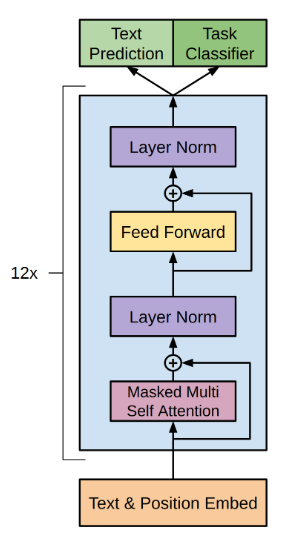

**Masked Self-Atenttion in the Decoder :**

When predicting future words, we don't want the attention module to cheat and look at the answer. So, we add an upper triangular matrix to the computed attention matrix (A = QK^T / sqrt(d_k) ), where all the values above its diagonal are set to -inf. In this way, each `q` (row) can only attend to the previous `k` (columns). When applying softmax to each row, the -inf values will turn to 0.

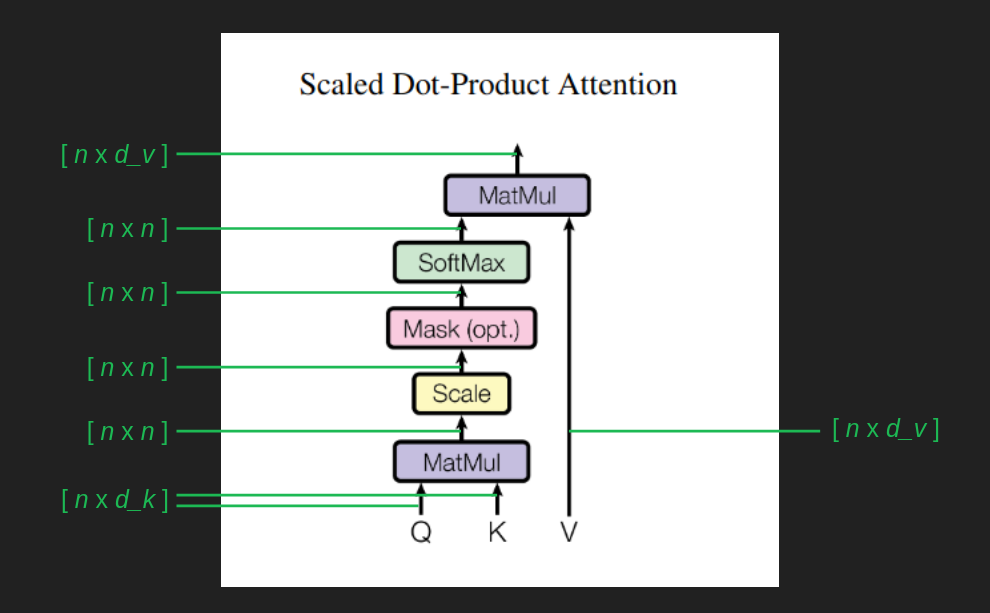

### Code for building Encoder and Decoder:

Note: In this code, the module called encoder is actually the one that can be used to text generation, masked modelling,... (like BERT).

In [ ]:
class EncoderLayer(NNModule):
    def __init__(self, hidden_size, num_heads, d_model, conv_hidden_dim, p, eps=1e-6, layer_name="EncL"):
        super().__init__()
        self.mha = MultiHeadAttention(hidden_size, num_heads, d_model, p, layer_name=layer_name)
        self.cnn = CNN(d_model, conv_hidden_dim, layer_name=layer_name + "_CNN")

        self.layernorm1 = LayerNormalization(normal_shape=d_model, epsilon=1e-6, layer_name=layer_name + "_LN1")
        self.layernorm2 = LayerNormalization(normal_shape=d_model, epsilon=1e-6, layer_name=layer_name + "_LN2")

    def forward(self, X):
        
        # Multi-head attention 
        attn_output, attn_weights = self.mha.forward(X)  # (seq_length, self.d_model)

        # Layer norm after adding the residual connection 
        out1 = self.layernorm1.forward(X + attn_output)  # (seq_length, self.d_model)
        
        # Feed forward 
        cnn_output = self.cnn.forward(out1)  # (seq_length, self.d_model)
        
        #Second layer norm after adding residual connection 
        out2 = self.layernorm2.forward(out1 + cnn_output)  # (seq_length, self.d_model)

        return out2, attn_weights



class Encoder(NNModule):
    def __init__(self, num_layers, ff_hidden_dim, num_heads, d_model, conv_hidden_dim, input_vocab_size,
               maximum_position_encoding, p=0.1, eps=1e-6, de_embedd=False):
        super().__init__()
        self.d_model = d_model #number of dimensions in the embedding space used throughout the model.
        self.num_layers = num_layers
        self.ff_hidden_dim = ff_hidden_dim
        self.num_heads = num_heads
        self.conv_hidden_dim = conv_hidden_dim
        self.p = p
        self.eps = eps
        self.de_embedd = de_embedd #convert final output embedded vectors into the actual one-hot encoded tokens

        self.embedding = Embeddings(d_model, input_vocab_size, maximum_position_encoding, p)

        #self.enc_layer= EncoderLayer(ff_hidden_dim, num_heads, d_model, conv_hidden_dim, p, eps)
    
    def __createEncLayer(self, i):
        #parameters are not shared across layers nor heads, only across timesteps/input positions
        enc_layer = EncoderLayer(self.ff_hidden_dim, self.num_heads, self.d_model, 
            self.conv_hidden_dim, self.p, self.eps, layer_name="EncL%i"%i)
        return enc_layer
        
    def forward(self, X):
        # X.shape = (bs, seq_length, input features)
        X, _, _ = self.embedding.forward(X) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            X, A = self.__createEncLayer(i).forward(X)
            self.store_attention_weights(A, layername="ATT%i"%i)
            #X = self.enc_layer.forward(X)

        if self.de_embedd:
            X = self.embedding.de_embedd(X)

        return X  # (batch_size, input_seq_len, d_model)

Note: the Decoder is only used with cross-attention, for translations purposes (joining Encoder and Decoder classes)

In [ ]:
class DecoderLayer(NNModule):
    def __init__(self, hidden_size, num_heads, d_model, conv_hidden_dim, p, eps=1e-6, layer_name="DecL"):
        super().__init__()
        #self.layer_name = layer_name
        self.mha = MultiHeadAttention(hidden_size, num_heads, d_model, p, layer_name=layer_name)
        self.cnn = CNN(d_model, conv_hidden_dim, layer_name=layer_name + "_CNN")

        self.layernorm1 = LayerNormalization(normal_shape=d_model, epsilon=1e-6, layer_name=layer_name + "_LN1")
        self.layernorm2 = LayerNormalization(normal_shape=d_model, epsilon=1e-6, layer_name=layer_name + "_LN2")
        self.layernorm3 = LayerNormalization(normal_shape=d_model, epsilon=1e-6, layer_name=layer_name + "_LN3")

    def forward(self, Henc, Y, mask=None):
        
        # Multi-head attention 
        attn_output, attn_weights = self.mha.forward(Y, mask)  # (seq_length, self.d_model)
        # Layer norm after adding the residual connection 
        out1 = self.layernorm1.forward(Y + attn_output)  # (seq_length, self.d_model)

        #CROSS-ATTENTION
        attn_output_cross, attn_weights_cross = self.mha.forward_crossattention(Henc, out1)  # (seq_length, self.d_model)
        out2 = self.layernorm2.forward(out1 + attn_output_cross)
        
        # Feed forward 
        cnn_output = self.cnn.forward(out2)  # (seq_length, self.d_model)
        
        #Second layer norm after adding residual connection 
        out3 = self.layernorm2.forward(out2 + cnn_output)  # (seq_length, self.d_model)

        return out3, [attn_weights, attn_weights_cross]



class Transformer(NNModule):
    def __init__(self, num_layers, ff_hidden_dim, num_heads, d_model, conv_hidden_dim, input_vocab_size,
               maximum_position_encoding, p=0.1, eps=1e-6, mask_decoder=True, de_embedd=False):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.ff_hidden_dim = ff_hidden_dim
        self.num_heads = num_heads
        self.conv_hidden_dim = conv_hidden_dim
        self.p = p
        self.eps = eps

        self.mask_decoder = mask_decoder
        self.de_embedd = de_embedd #convert final output embedded vectors into the actual one-hot encoded tokens

        # Full encoder first
        #self.encoder = Encoder(num_layers, ff_hidden_dim, num_heads, d_model, conv_hidden_dim, input_vocab_size,
               #maximum_position_encoding, p=0.1, eps=1e-6)

        # Embeddings for the decoder's and encoder's input
        self.embedding = Embeddings(d_model, input_vocab_size, maximum_position_encoding, p)

        #self.enc_layer= EncoderLayer(ff_hidden_dim, num_heads, d_model, conv_hidden_dim, p, eps)
    
    def __createDecLayer(self, i):
        enc_layer = DecoderLayer(self.ff_hidden_dim, self.num_heads, self.d_model, 
            self.conv_hidden_dim, self.p, self.eps, layer_name="DecL%i"%i)
        return enc_layer
    
    def create_subsequent_maks(self, seq_length):
        mask = np.tril(np.ones((seq_length,seq_length))) 
        return mask
    
    def __createEncLayer(self, i):
        enc_layer = EncoderLayer(self.ff_hidden_dim, self.num_heads, self.d_model, 
            self.conv_hidden_dim, self.p, self.eps, layer_name="EncL%i"%i)
        return enc_layer
        
    def forward(self, X, Y):
        # X.shape = (bs, seq_length, input features)
        X, _, _ = self.embedding.forward(X) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            Henc, A = self.__createEncLayer(i).forward(X)
            self.store_attention_weights(A, layername="ATT%i"%i)

        Y, _, _ = self.embedding.forward(Y) #same embedding weights used for the encoder's input

        if self.mask_decoder:
            mask = self.create_subsequent_maks(Y.shape[1])

        for i in range(self.num_layers):
            Y, A = self.__createDecLayer(i).forward(Henc, Y, mask)
            self.store_attention_weights(A, layername="ATT%i"%i)
            #X = self.enc_layer.forward(X)

        if self.de_embedd:
            X = self.embedding.de_embedd(X)

        return Y # (batch_size, input_seq_len, d_model)

### **Tokenizing:**



1.   List every vocabulary word in one-hot encoding representation.


*   Not optimal, due to the amount of existing variations of words (plural, gender,...) and also to possible mispelling errors in the data.


2.  [Byte pair encoding.](https://en.m.wikipedia.org/wiki/Byte_pair_encoding)

3.  If the dat is already in the form of dense vectors, we can skip the processes of tokenization and embeddings (*e.g.:* audio input).


# Summary



1.   **Embeddings:** map words from the vocabulary size to a lower dimensional space that learns patterns and clusters/groups similar words together.
2.   **Multi-head attention:** computes num_heads `q`, `k` and `v` for each sequence element/word and outputs a selective context vector `h` for each `q`. Each attention head is like a pairwise interaction: each `q` only attends to one word in the sequence, outputting this relevant one-word context relation in `h`. All num_heads `h` are concatenated and converted to the embedded space, resulting in one vectot per sequence element which encodes the multiple embedded word representations that describe the sequence at that point (relevant context associated to the sequence element in question).
3.   **Feed-Foward:** projects the context vector `h` into a representation of the present and absent multi-word combination features in that vector. Then, converts these into a probability distribution over the input embedded space (which embedded representations/patterns/clusters are more likely to happen, considering the multi-word combination features that appeared/ocurred in the relevant context of each sequence element).
4.   **De-Embeddings:** convert this final embedded representation in the most likely token, using a linear layer (where the weights matrix is the transpose of the embeddings one) + softmax.
5.   **Parallelization:** this can be done simultaneously for multiple words (a whole sequence), by stacking each word as a row, inputing 2D-matrices.

